In [39]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

#helpper function
import numpy as np

def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [3]:
# read the data in
df = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

In [5]:
# take a look at the dataset
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [6]:
# rename the 'rank' column because there is also a DataFrame method called 'rank'
df.columns = ["admit", "gre", "gpa", "prestige"]
print df.columns

Index([u'admit', u'gre', u'gpa', u'prestige'], dtype='object')


## Summary Statistics & Looking at the data
Now that we've got everything loaded into Python and named appropriately let's take a look at the data. We can use the pandas function describe to give us a summarized view of everything--describe is analogous to summary in R. There's also function for calculating the standard deviation, std. I've included it here to be consistent UCLA's tutorial, but the standard deviation is also included in describe.

A feature I really like in pandas is the pivot_table/crosstab aggregations. crosstab makes it really easy to do multidimensional frequency tables (sort of like table in R). You might want to play around with this to look at different cuts of the data.

In [7]:
# summarize the data
print df.describe()

            admit         gre         gpa   prestige
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000


In [8]:
# take a look at the standard deviation of each column
print df.std()

admit         0.466087
gre         115.516536
gpa           0.380567
prestige      0.944460
dtype: float64


In [9]:
# frequency table cutting presitge and whether or not someone was admitted
print pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige   1   2   3   4
admit                   
0         28  97  93  55
1         33  54  28  12


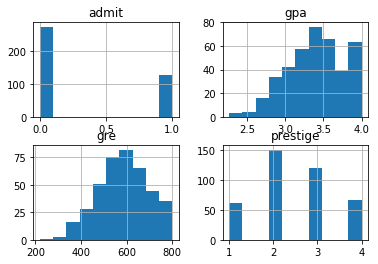

In [10]:
# plot all of the columns
df.hist()
pl.show()

## dummy variables
pandas gives you a great deal of control over how categorical variables are represented. We're going dummify the "prestige" column using get_dummies.

get_dummies creates a new DataFrame with binary indicator variables for each category/option in the column specified. In this case, prestige has four levels: 1, 2, 3 and 4 (1 being most prestigious). When we call get_dummies, we get a dataframe with four columns, each of which describes one of those levels.

In [14]:
# dummify rank
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print dummy_ranks.head()

   prestige_1  prestige_2  prestige_3  prestige_4
0           0           0           1           0
1           0           0           1           0
2           1           0           0           0
3           0           0           0           1
4           0           0           0           1


In [25]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit  gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380  3.61           0           1           0
1      1  660  3.67           0           1           0
2      1  800  4.00           0           0           0
3      1  640  3.19           0           0           1
4      0  520  2.93           0           0           1


Once that's done, we merge the new dummy columns into the original dataset and get rid of the prestige column which we no longer need.

Lastly we're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [26]:
# manually add the intercept
data['intercept'] = 1.0
print data.head()

   admit  gre   gpa  prestige_2  prestige_3  prestige_4  intercept
0      0  380  3.61           0           1           0        1.0
1      1  660  3.67           0           1           0        1.0
2      1  800  4.00           0           0           0        1.0
3      1  640  3.19           0           0           1        1.0
4      0  520  2.93           0           0           1        1.0


## Performing the regression
Actually doing the Logistic Regression is quite simple. Specify the column containing the variable you're trying to predict followed by the columns that the model should use to make the prediction.

In our case we'll be predicting the admit column using gre, gpa, and the prestige dummy variables prestige_2, prestige_3 and prestige_4. We're going to treat prestige_1 as our baseline and exclude it from our fit. This is done to prevent multicollinearity, or the dummy variable trap caused by including a dummy variable for every single category.


Since we're doing a logistic regression, we're going to use the statsmodels Logit function. For details on other models available in statsmodels, check out their docs [here](http://www.statsmodels.org/stable/index.html).


In [27]:
train_cols = data.columns[1:]
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)

logit = sm.Logit(data['admit'], data[train_cols])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


## Interpreting the results
One of my favorite parts about statsmodels is the summary output it gives. If you're coming from R, I think you'll like the output and find it very familiar too.

In [30]:
# cool enough to deserve it's own gist
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 Jul 2017   Pseudo R-squ.:                 0.08292
Time:                        15:40:47   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.070      0.038         0.000     0.004
gpa            0.8040      0.332      2.423      0.015         0.154     1.454
prestige_2    -0.6754      0.316     -2.134      0.0

You get a great overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures.

The result object also lets you to isolate and inspect parts of the model output. The confidence interval gives you an idea for how robust the coefficients of the model are.

In [31]:
# look at the confidence interval of each coeffecient
print result.conf_int()

                   0         1
gre         0.000120  0.004409
gpa         0.153684  1.454391
prestige_2 -1.295751 -0.055135
prestige_3 -2.016992 -0.663416
prestige_4 -2.370399 -0.732529
intercept  -6.224242 -1.755716


In this example, we're very confident that there is an inverse relationship between the probability of being admitted and the prestige of a candidate's undergraduate school.

In other words, the probability of being accepted into a graduate program is higher for students who attended a top ranked undergraduate college (prestige_1==True) as opposed to a lower ranked school with, say, prestige_4==True (remember, a prestige of 1 is the most prestigious and a prestige of 4 is the least prestigious.

## odds ratio
Take the exponential of each of the coefficients to generate the odds ratios. This tells you how a 1 unit increase or decrease in a variable affects the odds of being admitted. For example, we can expect the odds of being admitted to decrease by about 50% if the prestige of a school is 2. UCLA gives a more in depth explanation of the odds ratio here.

In [32]:
result.params

gre           0.002264
gpa           0.804038
prestige_2   -0.675443
prestige_3   -1.340204
prestige_4   -1.551464
intercept    -3.989979
dtype: float64

In [33]:
# odds ratios and 95% CI
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                2.5%     97.5%        OR
gre         1.000120  1.004418  1.002267
gpa         1.166122  4.281877  2.234545
prestige_2  0.273692  0.946358  0.508931
prestige_3  0.133055  0.515089  0.261792
prestige_4  0.093443  0.480692  0.211938
intercept   0.001981  0.172783  0.018500


## Digging a little deeper
As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian which I originally found here.

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [36]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 

gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres

gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [52]:
# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
combos
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
combos

dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']
dummy_ranks

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
combos
train_cols

# make predictions on the enumerated dataset
combos['admit_pred'] = result.predict(combos[train_cols])
print combos.head()

     gre       gpa  prestige  intercept  prestige_2  prestige_3  prestige_4  \
0  220.0  2.260000       1.0        1.0           0           0           0   
1  220.0  2.260000       2.0        1.0           1           0           0   
2  220.0  2.260000       3.0        1.0           0           1           0   
3  220.0  2.260000       4.0        1.0           0           0           1   
4  220.0  2.453333       1.0        1.0           0           0           0   

   admit_pred  
0    0.157801  
1    0.087056  
2    0.046758  
3    0.038194  
4    0.179574  


In [44]:
cartesian( [ [1,2], [20, 30, 40], ['100', '200']])

array([[  1,  20, 100],
       [  1,  20, 200],
       [  1,  30, 100],
       [  1,  30, 200],
       [  1,  40, 100],
       [  1,  40, 200],
       [  2,  20, 100],
       [  2,  20, 200],
       [  2,  30, 100],
       [  2,  30, 200],
       [  2,  40, 100],
       [  2,  40, 200]])